In [1]:
# torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms import transforms
import torch.optim as optim
# utils
import os
from glob import glob
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix


In [2]:
import torch
import glob
import os
import random

# Global variables
device = "cuda" if torch.cuda.is_available() else "cpu"
dataset_path = "relevent and irrelevent"
image_size = (224, 224)
num_classes = 2

irrelevent_image_paths = glob.glob(os.path.join(dataset_path, "irrelevent", "*.jpg")) + glob.glob(os.path.join(dataset_path, "irrelevent", "*.png"))
relevent_image_paths = glob.glob(os.path.join(dataset_path, "relevent", "*.jpg")) + glob.glob(os.path.join(dataset_path, "relevent", "*.png"))

# Combine the paths and shuffle them
image_paths = irrelevent_image_paths + relevent_image_paths
random.shuffle(image_paths)

# Split the image paths into train and test sets
train_ratio = 0.8  # 80% for training, 20% for testing
train_size = int(train_ratio * len(image_paths))
train_paths = image_paths[:train_size]
test_paths = image_paths[train_size:]

# Check device
print(device)

# Print the number of images in each set for verification
print(f"Total images: {len(image_paths)}")
print(f"Training set size: {len(train_paths)}")
print(f"Testing set size: {len(test_paths)}")


cpu
Total images: 464
Training set size: 371
Testing set size: 93


In [3]:
# data augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
# custom dataset class
class dataset(Dataset):
    def __init__(self,paths,transform=None):
        self.paths = paths
        self.transform = transform
        self.labels = [self.get_label(path) for path in self.paths]
        self.labels_to_index = {label:index for index,label in enumerate(list(set(self.labels)))}
    
    def __getitem__(self,index):
        img_path = self.paths[index]
        img = Image.open(img_path).convert('RGB') 
        label = self.labels[index]
        label_index = self.labels_to_index[label]
        
        if self.transform:
            img = self.transform(img)
        
        return img, label_index,label
    
    
    def __len__(self):
        return len(self.paths)
    
    
    def get_label(self, path):
        return os.path.basename(os.path.dirname(path))

In [5]:
train_dataset = dataset(train_paths, transform=train_transform)
test_dataset = dataset(test_paths, transform=test_transform)
val_dataset, test_dataset = train_test_split(test_dataset,test_size=0.5)

In [6]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
val_loader

C:\Users\0871\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\0871\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Train Loss: 0.1107, Train Acc: 95.15%, Val Loss: 0.0003, Val Acc: 100.00%
Epoch 2: Train Loss: 0.0121, Train Acc: 99.73%, Val Loss: 0.0000, Val Acc: 100.00%
Epoch 3: Train Loss: 0.0075, Train Acc: 99.73%, Val Loss: 0.0000, Val Acc: 100.00%
Epoch 4: Train Loss: 0.0021, Train Acc: 100.00%, Val Loss: 0.0001, Val Acc: 100.00%
Epoch 5: Train Loss: 0.0008, Train Acc: 100.00%, Val Loss: 0.0001, Val Acc: 100.00%


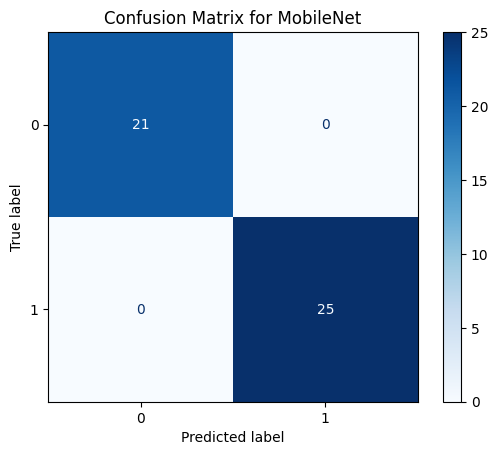

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        25

    accuracy                           1.00        46
   macro avg       1.00      1.00      1.00        46
weighted avg       1.00      1.00      1.00        46



In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


# Model definition
class MobileNetModel(nn.Module):
    def __init__(self, num_classes):
        super(MobileNetModel, self).__init__()
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        num_features = self.mobilenet.classifier[1].in_features
        self.mobilenet.classifier[1] = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.mobilenet(x)

# Initialize the model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MobileNetModel(num_classes=2).to(device)  # Set num_classes appropriately
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002)

def train_epoch():
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for batch in train_loader:
        data = batch[0].to(device)
        labels = batch[1].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_predictions += (preds == labels).sum().item()
        total_predictions += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    accuracy = correct_predictions / total_predictions
    return avg_loss, accuracy

def eval_model(loader):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in loader:
            data = batch[0].to(device)
            labels = batch[1].to(device)
            outputs = model(data)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_predictions += (preds == labels).sum().item()
            total_predictions += labels.size(0)

    avg_loss = running_loss / len(loader)
    accuracy = correct_predictions / total_predictions
    return avg_loss, accuracy

# Main training loop
best_score = float("inf")
n_epochs = 5
tolerance = 0

for epoch in range(n_epochs):
    train_loss, train_acc = train_epoch()
    val_loss, val_acc = eval_model(val_loader)

    if val_loss < best_score:
        best_score = val_loss
        torch.save(model.state_dict(), "mobilenet_irrelevent.pt")
        tolerance = 0
    else:
        tolerance += 1
        if tolerance >= 8:
            break

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

# Generate predictions and true labels
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for batch in val_loader:
        data = batch[0].to(device)
        labels = batch[1].to(device)
        outputs = model(data)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for MobileNet")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds))


In [12]:
import torch
from torchvision import transforms
from PIL import Image
import os

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image transformations
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the model class (same as the one used during training)
class MobileNetModel(nn.Module):
    def __init__(self, num_classes):
        super(MobileNetModel, self).__init__()
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        num_features = self.mobilenet.classifier[1].in_features
        self.mobilenet.classifier[1] = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.mobilenet(x)

# Load the trained model
model = MobileNetModel(num_classes=2)
model.load_state_dict(torch.load("mobilenet_irrelevent.pt"))
model = model.to(device)
model.eval()

def predict_image(image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image = image_transform(image).unsqueeze(0)  # Add batch dimension
    image = image.to(device)

    # Perform the prediction
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)

    return predicted.item()

# Helper function to map the prediction to label
def map_prediction_to_label(prediction):
    label_mapping = {0: "irrelevent", 1: "relevent"}
    return label_mapping.get(prediction, "Unknown")

# Example usage
image_path = r"relevent and irrelevent\irrelevent\003_4v9BJPhzwVo.jpg"
prediction = predict_image(image_path)
predicted_label = map_prediction_to_label(prediction)

print(f"The predicted label for the image is: {predicted_label}")


The predicted label for the image is: irrelevent


C:\Users\0871\AppData\Local\Temp\ipykernel_15868\3055821361.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("mobilenet_irrelevent.pt"))